In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [2]:
Type_farmer = 1
Type_tailor = 2
Type_business = 3

In [3]:
class AllinOne(nn.Module):
    def __init__(self,dna = None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(7,16),
            nn.ReLU(),
            nn.Linear(16,5)
        )
        if(dna == None): self.apply(self._init_weights)
        else: self.set_gene(dna)
        

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, a=-3.0, b=3.0)  
    
    def forward(self,x):
        x = self.net(x)
        return x



In [4]:
def gene(network):
    flat_params = torch.cat([p.view(-1) for p in network.parameters()])
    return flat_params

def crossover(dna1,dna2):
    m = int(len(dna1) / 2)
    child = torch.cat([dna1[:m], dna2[m:]], dim=0)
    return child

def give_net(netName):
    if(netName == "AllinOne"): return AllinOne()
    return -1

def set_gene(gene,net):
    pointer = 0
    for param in net.parameters():
        numel = param.numel()
        new_values = gene[pointer:pointer+numel].view_as(param)
        with torch.no_grad():
            param.copy_(new_values)
        pointer+=numel
    return net

class Person():
    def __init__(self,brain = None):
        if(brain == None): self.brain = {}
        else: self.brain = brain

        self.food = 0
        self.clothes = 0
        self.luxury = 0
        self.money = 1

        self.score = 0

    def happiness(self):
        happy = 0 
        if(self.food>=1):
            happy += 10 + (self.food-1)*0.1
            self.food-=1
        else:
            happy =10*(1-self.food)
        if(self.clothes>=1):
            happy += 5 + (self.clothes-1)*0.2
            self.clothes-=1
        else:
            happy = 5*(1-self.clothes)
        if(self.luxury>0):
            happy += self.luxury*0.3
        self.score += happy 

class Farmer(Person):
    def __init__(self,brain = None):
        super().__init__(brain)
        if(brain == None):
            self.brain["AllinOne"] = AllinOne()

    def think(self,taxF,taxT,taxB):
        inp = torch.tensor([taxF,taxT,taxB,self.food,self.clothes,self.luxury,self.money],dtype=torch.float32)
        self.decision = self.brain["AllinOne"](inp)
        budget = self.decision[-4:]
        budget = F.softmax(budget,dim=0)*self.money

        self.decision = torch.cat([self.decision[:-4], budget])
        self.decision[0] = F.sigmoid(self.decision[0])

    def produce(self):
        self.food += 5

class Tailor(Person):
    def __init__(self,brain = None):
        super().__init__(brain)
        if(brain == None):
            self.brain["AllinOne"] = AllinOne()

    def think(self,taxF,taxT,taxB):
        inp = torch.tensor([taxF,taxT,taxB,self.food,self.clothes,self.luxury,self.money],dtype=torch.float32)
        self.decision = self.brain["AllinOne"](inp)
        budget = self.decision[-4:]
        budget = F.softmax(budget,dim=0)*self.money

        self.decision = torch.cat([self.decision[:-4], budget])
        self.decision[0] = F.sigmoid(self.decision[0])

    def produce(self):
        self.clothes += 3
    
class Business(Person):
    def __init__(self,brain = None):
        super().__init__(brain)
        if(brain == None):
            self.brain["AllinOne"] = AllinOne()

    def think(self,taxF,taxT,taxB):
        inp = torch.tensor([taxF,taxT,taxB,self.food,self.clothes,self.luxury,self.money],dtype=torch.float32)
        self.decision = self.brain["AllinOne"](inp)
        budget = self.decision[-4:]
        budget = F.softmax(budget,dim=0)*self.money

        self.decision = torch.cat([self.decision[:-4], budget])
        self.decision[0] = F.sigmoid(self.decision[0])

    def produce(self):
        self.luxury += 1

In [ ]:
class Pop():
    def __init__(self,type,count = 100,champion_percent = 0.3):
        self.count = count
        self.generation = []
        self.champion_percent = champion_percent
        self.type = type

        if(self.type == Type_farmer): self.generation = [Farmer() for x in range(count)]
        if(self.type == Type_tailor): self.generation = [Tailor() for x in range(count)]
        if(self.type == Type_business): self.generation = [Business() for x in range(count)]


    def get_new_generation(self):

        self.generation = sorted(self.generation,key = lambda x:x.score , reverse=True)
        new_generation = []

        for i in range(int(self.count * self.champion_percent)):
            new_generation.append(self.generation[i])
            new_generation[-1].food = 0
            new_generation[-1].clothes = 0
            new_generation[-1].luxury = 0
            new_generation[-1].money = 1
            new_generation[-1].score = 0
            
        while len(new_generation) < len(self.generation):
            new_generation.append(self.breed())
        
        self.generation = new_generation

    def breed(self):
        parents = []
        parents.append(random.choices(self.generation,weights=[x.score for x in self.generation],k=1)[0])
        remaining = [x for x in self.generation if x != parents[0]]
        parents.append(random.choices(remaining,weights=[x.score for x in remaining],k=1)[0])
        
        newbrain = {}
        for netName in parents[0].brain.keys():
            dna1 = gene(parents[0].brain[netName])
            dna2 = gene(parents[1].brain[netName])

            net = give_net(netName)
            child_dna = crossover(dna1,dna2)
            net = set_gene(child_dna,net)
            newbrain[netName] = net

        if(self.type == Type_farmer): return Farmer(newbrain)
        if(self.type == Type_tailor): return Tailor(newbrain)
        if(self.type == Type_business): return Business(newbrain)

In [6]:
def simulate(farmers,tailors,businesses,taxF,taxT,taxB):
    fm = 0 
    cm = 0
    lm =0 
    
    for i in range(farmers.count):
        farmers.generation[i].produce()
        farmers.generation[i].think(taxF,taxT,taxB)
        fm += float(farmers.generation[i].decision[1])
        cm += float(farmers.generation[i].decision[2])
        lm += float(farmers.generation[i].decision[3])
        farmers.generation[i].money -= farmers.generation[i].decision[1]+farmers.generation[i].decision[2]+farmers.generation[i].decision[3]

    for i in range(tailors.count):
        tailors.generation[i].produce()
        tailors.generation[i].think(taxF,taxT,taxB)
        fm += float(tailors.generation[i].decision[1])
        cm += float(tailors.generation[i].decision[2])
        lm += float(tailors.generation[i].decision[3])
        tailors.generation[i].money -= tailors.generation[i].decision[1]+tailors.generation[i].decision[2]+tailors.generation[i].decision[3]

    for i in range(businesses.count):
        businesses.generation[i].produce()
        businesses.generation[i].think(taxF,taxT,taxB)
        fm += float(businesses.generation[i].decision[1])
        cm += float(businesses.generation[i].decision[2])
        lm += float(businesses.generation[i].decision[3])
        businesses.generation[i].money -= businesses.generation[i].decision[1]+businesses.generation[i].decision[2]+businesses.generation[i].decision[3]

    farmers.generation = sorted(farmers.generation,key=lambda b:b.decision[0])
    tailors.generation = sorted(tailors.generation,key=lambda b:b.decision[0])
    businesses.generation = sorted(businesses.generation,key=lambda b:b.decision[0])

    fm_total = fm
    cm_total = cm
    lm_total = lm

    food_bought = 0
    clothes_bought = 0
    luxuries_bought = 0

    #Check how many clothes can be bought
    for i in range(0,len(farmers.generation)):
        total_cost = float(farmers.generation[i].decision[0]*farmers.generation[i].food)
        if(fm<total_cost):
            fb = (fm/total_cost)*farmers.generation[i].food
            food_bought += fb
            farmers.generation[i].food -= fb
            farmers.generation[i].money += fm
            fm = 0
        else:
            food_bought += farmers.generation[i].food
            farmers.generation[i].food = 0
            farmers.generation[i].money += total_cost
            fm -= total_cost
    #Check how many clothes can be bought
    for i in range(0,len(tailors.generation)):
        total_cost = float(tailors.generation[i].decision[0]*tailors.generation[i].clothes)
        if(cm<total_cost):
            cb = (cm/total_cost)*tailors.generation[i].clothes
            clothes_bought += cb
            tailors.generation[i].clothes -= cb
            tailors.generation[i].money+=cm
            cm = 0
        else:
            clothes_bought += tailors.generation[i].clothes
            tailors.generation[i].clothes = 0
            tailors.generation[i].money += total_cost
            cm -= total_cost
    
    for i in range(0,len(businesses.generation)):
        total_cost = float(businesses.generation[i].decision[0]*businesses.generation[i].luxury)
        if(lm<total_cost):
            lb = (lm/total_cost)*businesses.generation[i].luxury
            luxuries_bought += lb
            businesses.generation[i].luxury -= lb
            businesses.generation[i].money += lm
            lm = 0
        else:
            luxuries_bought += float(businesses.generation[i].luxury)
            businesses.generation[i].luxury = 0
            businesses.generation[i].money+= total_cost
            lm -= total_cost

    #Redistribute items and leftover money
    
    for f in farmers.generation:
        f.food += float((f.decision[1]/fm_total)*food_bought)
        f.clothes += float((f.decision[2]/cm_total)*clothes_bought)
        f.luxury += float((f.decision[3]/lm_total)*luxuries_bought)
        f.money += float((f.decision[1]/fm_total)*fm + (f.decision[2]/cm_total)*cm + (f.decision[3]/lm_total)*lm)
        f.happiness()
        
    for t in tailors.generation:
        t.food += float((t.decision[1]/fm_total)*food_bought)
        t.clothes += float((t.decision[2]/cm_total)*clothes_bought)
        t.luxury += float((t.decision[3]/lm_total)*luxuries_bought)
        t.money += float((t.decision[1]/fm_total)*fm + (t.decision[2]/cm_total)*cm + (t.decision[3]/lm_total)*lm)
        t.happiness()

    for b in businesses.generation:
        b.food += float((b.decision[1]/fm_total)*food_bought)
        b.clothes += float((b.decision[2]/cm_total)*clothes_bought)
        b.luxury += float((b.decision[3]/lm_total)*luxuries_bought)
        b.money += float((b.decision[1]/fm_total)*fm + (b.decision[2]/cm_total)*cm + (b.decision[3]/lm_total)*lm)
        b.happiness()

In [7]:
farmers = Pop(Type_farmer)
tailors = Pop(Type_tailor)
businesses = Pop(Type_business)      

for i in range(0,10):
    simulate(farmers,tailors,businesses,0,0,0)

In [8]:
#Do some metrices for everyone
print("BEST Farmer ",max(f.score for f in farmers.generation))
print("BEST Trader ",max(t.score for t in tailors.generation))
print("BEST business ",max(b.score for b in businesses.generation))
print("WORST Farmer ",min(f.score for f in farmers.generation))
print("WORST Trader ",min(t.score for t in tailors.generation))
print("WORST business ",min(b.score for b in businesses.generation))

BEST Farmer  232.63444947894845
BEST Trader  496.0105186505598
BEST business  198.26827817884453
WORST Farmer  35.482780918794184
WORST Trader  45.197239162410014
WORST business  7.3157843655948


In [9]:
farmers = Pop(Type_farmer)
tailors = Pop(Type_tailor)
businesses = Pop(Type_business)      

avg_farmer = []
avg_tailor = []
avg_business = []

best_farmer = []
best_tailor = []
best_business = []

for i in range(0,100):
    for j in range(0,10):
        simulate(farmers,tailors,businesses,0,0,0)
    avg_farmer.append(sum([f.score for f in farmers.generation])/len(farmers.generation))
    avg_tailor.append(sum([t.score for t in tailors.generation])/len(tailors.generation))
    avg_business.append(sum([b.score for b in businesses.generation])/len(businesses.generation))
    best_farmer.append(max([f.score for f in farmers.generation]))
    best_tailor.append(max([t.score for t in tailors.generation]))
    best_business.append(max([b.score for b in businesses.generation]))
    farmers.get_new_generation()
    tailors.get_new_generation()
    businesses.get_new_generation()


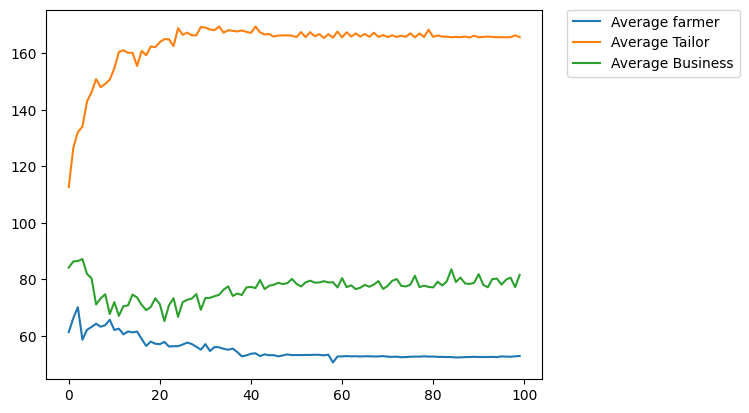

In [10]:
import matplotlib.pyplot as plt

plt.plot(avg_farmer,label="Average farmer")
plt.plot(avg_tailor,label="Average Tailor")
plt.plot(avg_business,label="Average Business")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

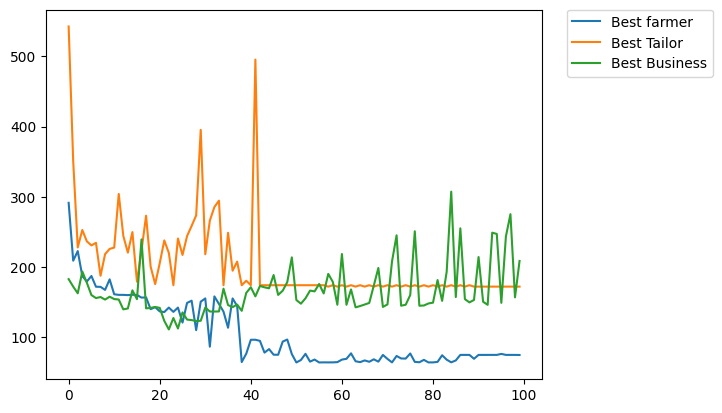

In [11]:

plt.plot(best_farmer,label="Best farmer")
plt.plot(best_tailor,label="Best Tailor")
plt.plot(best_business,label="Best Business")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)